## Notebook setup

In [237]:
import os
import io
import warnings
import datetime
import numpy as np
import base64
import dotenv

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from IPython.display import HTML

from openbb_terminal.reports import widget_helpers as widgets
from openbb_terminal.sdk import openbb
from openbb_terminal import config_terminal as cfg
from openbb_terminal.helper_classes import TerminalStyle
from openbb_terminal.core.config.paths import USER_ENV_FILE, REPOSITORY_DIRECTORY
import yfinance as yf
import pandas as pd

from jinja2 import Template

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

In [238]:
cfg.theme = TerminalStyle("light", "light", "light")

stylesheet = widgets.html_report_stylesheet()

## Select symbol

In [239]:
# Parameters that will be replaced when calling this notebook
# Do not leave parameters blank as notebook will not run otherwise
symbol = "SDE"
exchange = "TSX"

long_name = "Spartan Delta"
report_name = f"{symbol}".upper()
 

In [240]:
if "." in symbol:
    import sys

    sys.exit(0)
symbol = symbol.upper()

In [241]:
ticker_data = openbb.stocks.load(
    symbol=symbol+".TO", start_date=datetime.datetime.now() - datetime.timedelta(days=18 * 30)
)
ticker_data = openbb.stocks.process_candle(data=ticker_data)

author = ""
report_title = f"Investment Research Report on {symbol.upper()}"
report_date = datetime.datetime.now().strftime("%d %B, %Y")
report_time = datetime.datetime.now().strftime("%H:%M")
report_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
report_title, report_date, report_time, report_timezone

Loading Daily data for SDE.TO with starting period 2021-07-26.

('Investment Research Report on SDE',
 '17 January, 2023',
 '17:15',
 datetime.timezone(datetime.timedelta(days=-1, seconds=68400), 'Eastern Standard Time'))

## Data

In [242]:
tables = openbb.etf.news(f"{long_name}", 10)
for table in tables:
    table[0].loc["link"] = (
        table[0].loc["link"].apply(lambda x: f'<a href="{x}">{x}</a>')
    )

1 news articles for  Spartan Delta were found since 2023-01-10

In [243]:
df_institutional_shareholders = openbb.stocks.fa.shrs(symbol+".TO", holder="institutional")
df_institutional_shareholders.index += 1
df_institutional_shareholders

,Holder,Shares,Date Reported,Stake,Value
1,Eagle Bay Advisors Llc,4 K,2022-06-29,0.00 %,62.159 K


In [244]:
openbb.stocks.fa.shrs(symbol)

Error: 1

[]

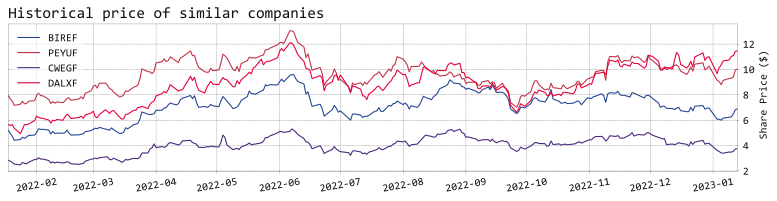

In [245]:
similar_companies=['BIREF','PEYUF','CWEGF','DALXF']

fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ca.hist_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
    normalize=False,
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
historical_similar = f.getvalue().decode("utf-8")

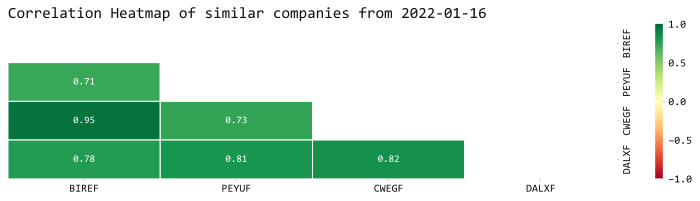

In [246]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ca.hcorr_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
hcorr_similar = f.getvalue().decode("utf-8")

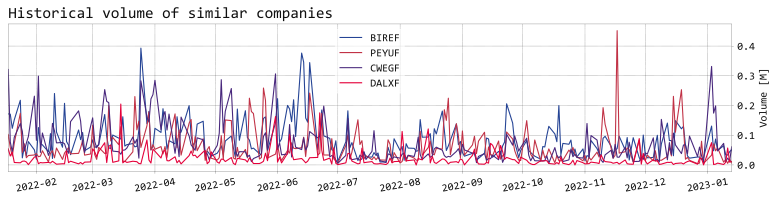

In [247]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ca.volume_chart(
    similar_companies,
    external_axes=[
        ax,
    ],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
vol_similar = f.getvalue().decode("utf-8")

In [248]:
income_comparison = openbb.stocks.ca.income(similar_companies)
income_comparison

Error: Timeframe selected should be one of 2017, 2018, 2019, 2020, 2021

[]

In [249]:
try:
    df_related_queries = openbb.stocks.ba.queries(symbol)
    df_related_queries.index += 1
    df_related_queries.index
except:
    pass

In [250]:
try:
    df_rising_queries = openbb.stocks.ba.rise(symbol)
    df_rising_queries.index += 1
    df_rising_queries
except:
    pass

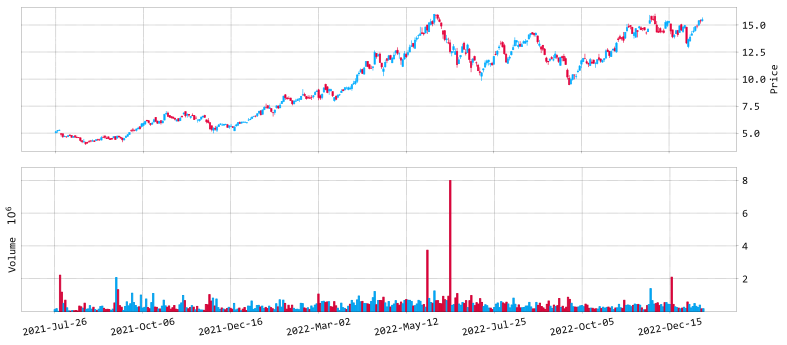

In [251]:
fig, (candles, volume) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.candle(
    symbol=symbol,
    data=ticker_data,
    use_matplotlib=True,
    external_axes=[candles, volume],
)
candles.set_xticklabels("")
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_chart = f.getvalue().decode("utf-8")

In [252]:
df = openbb.stocks.dd.pt(symbol=symbol)
avg_ratings_last_30_days = 0
days = 0
if not df.empty:
    df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]
    while df_ratings.empty:
        days += 30
        df_ratings = df[datetime.datetime.now() - datetime.timedelta(days=days) :]

        if days > 100:
            break

    if not df_ratings.empty:
        avg_ratings_last_30_days = round(np.mean(df_ratings["Price Target"].values), 2)
    else:
        avg_ratings = 0

last_price = round(ticker_data["Close"][-1], 2)

No ratings over time found

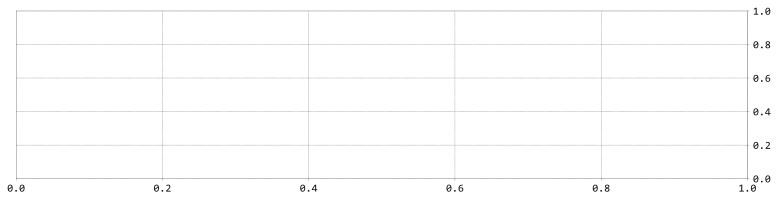

In [253]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.rot_chart(
    symbol=symbol,
    limit=10,
    raw=False,
    export="",
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ratings_over_time_chart = f.getvalue().decode("utf-8")

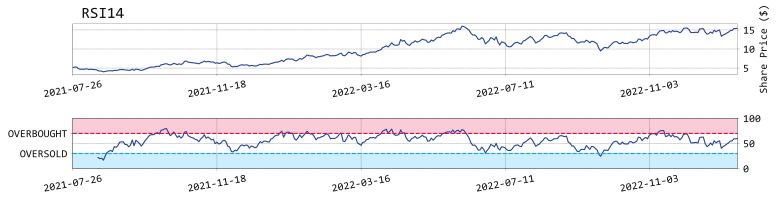

In [254]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 3), dpi=150)
openbb.ta.rsi_chart(ticker_data["Close"], external_axes=[ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ta_rsi = f.getvalue().decode("utf-8")

In [255]:
df = openbb.ta.rsi(ticker_data["Close"])
rsi_value = round(df.values[-1][0], 2)
rsi_value

60.21

In [256]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(
    np.array(range(len(ticker_data["Close"][-30:].index))).reshape(-1, 1),
    ticker_data["Close"][-30:].values,
)
regression_slope = round(model.coef_[0], 2)

In [257]:
import pandas as pd

df_insider = pd.DataFrame.from_dict(openbb.stocks.ins.lins(symbol=symbol)).head(10)
if (df_insider.empty):
    print("empty")
    last_10_insider_trading = 0
else:
    df_insider["Val ($)"] = df_insider["Value ($)"].replace({",": ""}, regex=True)
    df_insider["Trade"] = df_insider.apply(
        lambda row: (-1 * float(row["Val ($)"]))
        if row["Transaction"] == "Sale"
        else (float(row["Val ($)"]) if row["Transaction"] == "Buy" else 0),
        axis=1,
    )
    last_10_insider_trading = round(sum(df_insider["Trade"]) / 1_000_000, 2)
    df_insider = df_insider.drop(columns=["Val ($)", "Trade"])
    df_insider

There was an error connecting to the API. Please try again later.

empty


In [258]:
(
    watchlist_count,
    n_cases,
    n_bull,
    n_bear,
) = openbb.stocks.ba.bullbear(symbol=symbol)
stocktwits_sentiment = f"Watchlist count: {watchlist_count}</br>"
if n_cases > 0:
    stocktwits_sentiment += f"\nLast {n_cases} sentiment messages:</br>"
    stocktwits_sentiment += f"Bullish {round(100*n_bull/n_cases, 2)}%</br>"
    stocktwits_sentiment += f"Bearish {round(100*n_bear/n_cases, 2)}%"
else:
    stocktwits_sentiment += "No messages found"
stocktwits_sentiment

'Watchlist count: 50</br>\nLast 9 sentiment messages:</br>Bullish 100.0%</br>Bearish 0.0%'

In [259]:
ticker_data_all = openbb.stocks.load(
    symbol=symbol+".TO",
    start_date=datetime.datetime.now() - datetime.timedelta(days=5 * 12 * 21),
)
ticker_data_all["Returns"] = ticker_data_all["Adj Close"].pct_change()

Loading Daily data for SDE.TO with starting period 2019-08-06.

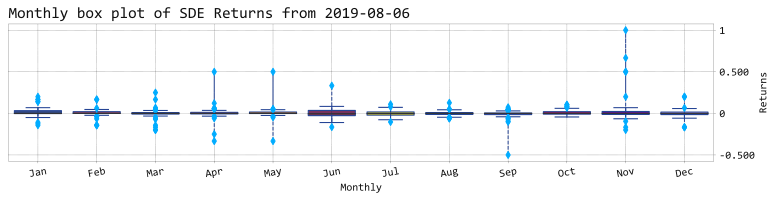

In [260]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=False,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_month = f.getvalue().decode("utf-8")

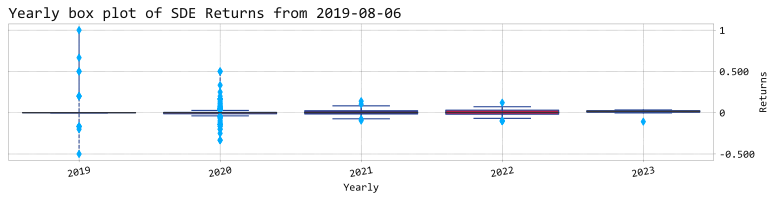

In [261]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.qa.bw(
    ticker_data_all,
    "Returns",
    symbol,
    yearly=True,
    external_axes=[ax],
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bw_year = f.getvalue().decode("utf-8")

In [262]:
income_df = openbb.stocks.fa.income(symbol+".TO", source="YahooFinance")
income_df = income_df/1000000
income_df = income_df.applymap("${0:.0f}M".format)

mgmt_df = openbb.stocks.fa.mgmt(symbol)
if (mgmt_df.empty):
    print ("empty")
else:
    mgmt_df["Info"] = mgmt_df["Info"].apply(lambda x: f'<a href="{x}">{x}</a>')
    mgmt_df["Insider Activity"] = mgmt_df["Insider Activity"].apply(
        lambda x: f'<a href="{x}">{x}</a>' if x != "-" else x
    )
try:
    hist_dcf = openbb.stocks.fa.dcf(symbol)
except:
    pass
enterprise_df = openbb.stocks.fa.enterprise(symbol)
score = openbb.stocks.fa.score(symbol)
if score:
    score = round(float(score), 2)

No management information in Business Insider for SDE

empty


Error: list index out of range

Ticker should be a NASDAQ 100 ticker or SP 500 ticker

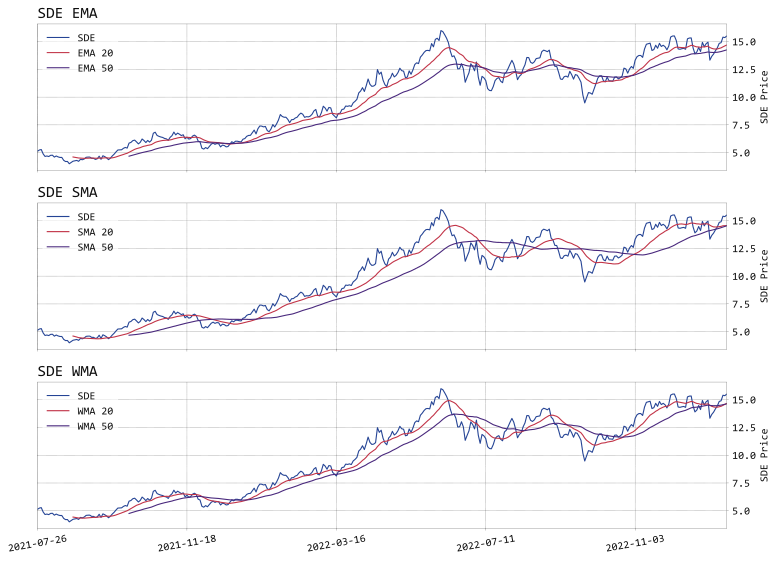

In [263]:
fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=3, ncols=1, figsize=(11, 8), sharex=True, dpi=150
)
openbb.ta.ma(ticker_data["Close"], symbol=symbol, external_axes=[ax1])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="SMA", external_axes=[ax2])
openbb.ta.ma(ticker_data["Close"], symbol=symbol, ma_type="WMA", external_axes=[ax3])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ma_chart = f.getvalue().decode("utf-8")

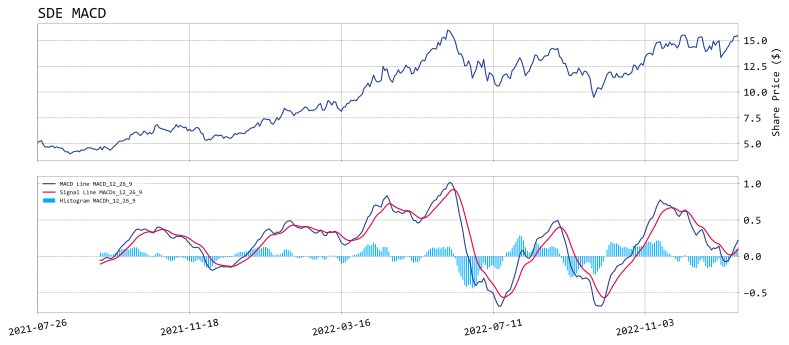

In [264]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.macd_chart(ticker_data["Close"], symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
macd_chart = f.getvalue().decode("utf-8")

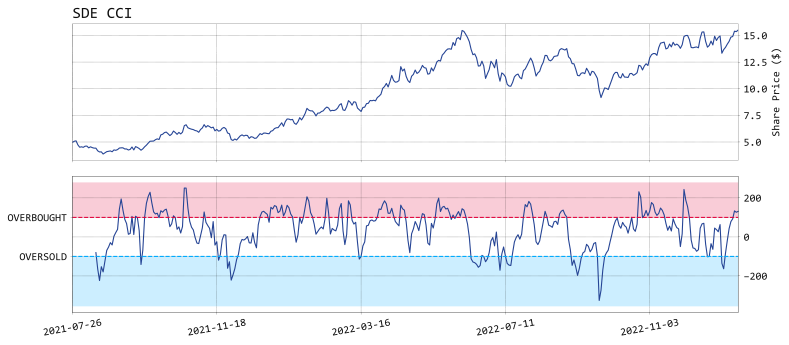

In [265]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), sharex=True, dpi=150)
openbb.ta.cci_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
cci_chart = f.getvalue().decode("utf-8")

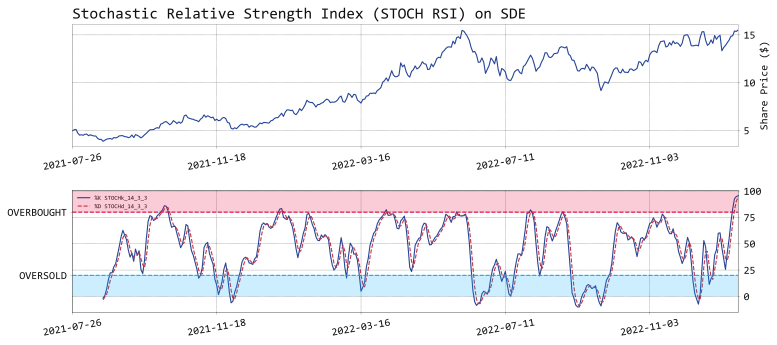

In [266]:
fig, (ax, ax1) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.ta.stoch_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
stoch_chart = f.getvalue().decode("utf-8")

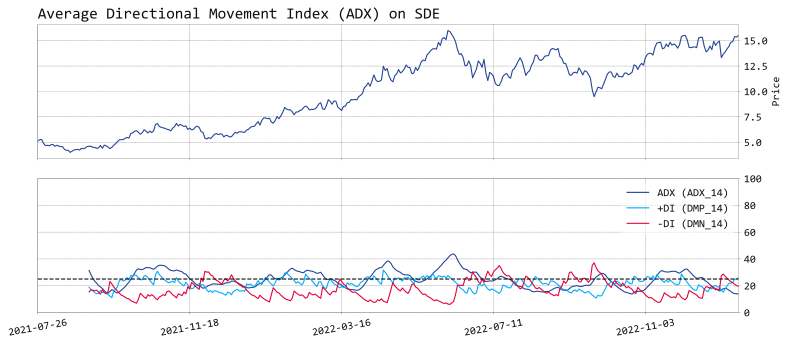

In [267]:
fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(11, 5), dpi=150)
openbb.ta.adx_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
adx_chart = f.getvalue().decode("utf-8")

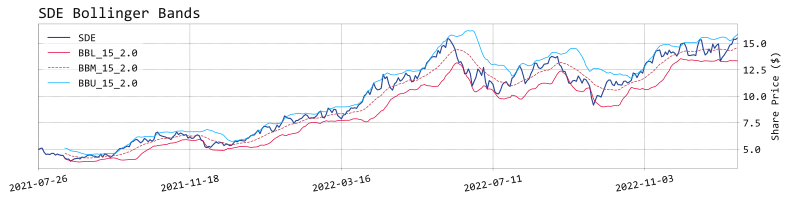

In [268]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.ta.bbands_chart(ticker_data, symbol=symbol, external_axes=[ax])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
bbands_chart = f.getvalue().decode("utf-8")

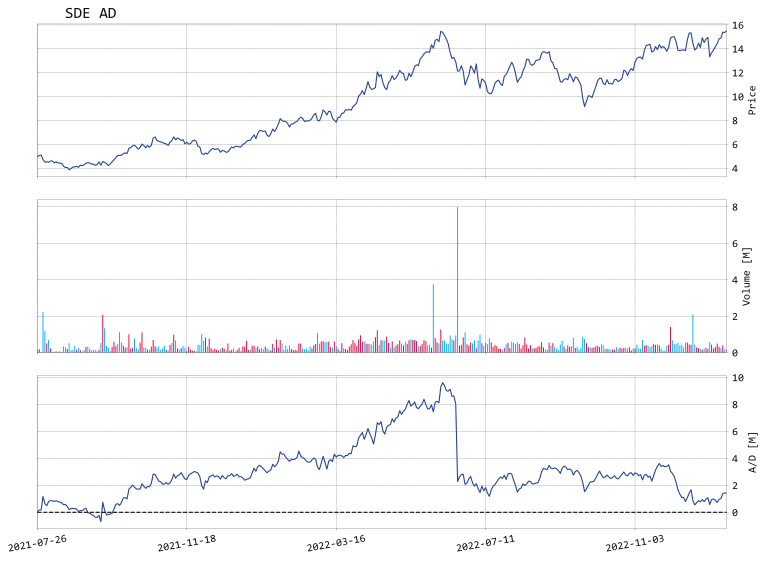

In [269]:
fig, (ax, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(11, 8), dpi=150)
openbb.ta.ad_chart(ticker_data, symbol=symbol, external_axes=[ax, ax1, ax2])
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ad_chart = f.getvalue().decode("utf-8")

## Render the report template to a file

In [271]:
body =""
    
img = (
    str(REPOSITORY_DIRECTORY)
    + "/openbb_terminal/reports/templates/OpenBB_reports_logo.png"
)
floppy_disk_img = (
    str(REPOSITORY_DIRECTORY) + "/openbb_terminal/reports/templates/floppy-disc.png"
)

htmlcode = f"""
<!-- TradingView Widget BEGIN -->
    <div class="tradingview-widget-container">
        <div class="tradingview-widget-container__widget"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/NYSE-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR key facts</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-symbol-profile.js" async>
        {{
        "width": "1085",
        "height": "700",
        "colorTheme": "light",
        "isTransparent": false,
        "symbol": "{exchange}:{symbol}",
        "locale": "en"
        }}
        </script>
    </div>
<!-- TradingView Widget END -->
"""


body += widgets.add_tab("Summary", htmlcode, False)


htmlcode = f"""
<!-- TradingView Widget BEGIN -->
<div class="tradingview-widget-container">
  <div id="tradingview_fceac"></div>
  <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/" rel="noopener" target="_blank"><span class="blue-text">AR stock price</span></a> by TradingView</div>
  <script type="text/javascript" src="https://s3.tradingview.com/tv.js"></script>
  <script type="text/javascript">
  new TradingView.MediumWidget(
    {{
    "symbols": [
        [
        "{long_name}",
        "{exchange}:{symbol}|1D"
        ]
    ],
    "chartOnly": false,
    "width": "1085",
    "height": "700",
    "locale": "en",
    "colorTheme": "light",
    "autosize": false,
    "showVolume": false,
    "hideDateRanges": false,
    "hideMarketStatus": false,
    "scalePosition": "right",
    "scaleMode": "Normal",
    "fontFamily": "-apple-system, BlinkMacSystemFont, Trebuchet MS, Roboto, Ubuntu, sans-serif",
    "fontSize": "10",
    "noTimeScale": false,
    "valuesTracking": "1",
    "chartType": "line",
    "container_id": "tradingview_fceac"
    }}
  );
  </script>
</div>
<!-- TradingView Widget END -->
"""

body += widgets.add_tab("Overview", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Latest News for " + symbol)])
try:
    for table in tables:
        htmlcode += widgets.row(
            [widgets.h(4, table[1]["title"]) + table[0].to_html(escape=False)]
        )
except:
    pass

htmlcode += widgets.row([widgets.h(3, "Twitter News for " + symbol )])

htmlcode += """
     <div class="tweet-list">
        {% for tweet in tweets %}
        <div class="tweet">
            <div class="tweet-header">
                <img src="{{ tweet.user.profile_image_url }}" alt="{{ tweet.user.name }}'s profile picture">
                <h3>{{ tweet.user.name }}</h3>                   
            </div>       
            <div class="tweet-body">
                <p>{{ tweet.full_text }}</p>
            </div>   
            {% if tweet.entities.media %}
                <div class="tweet-media">
                {% for media in tweet.entities.media %}
                    <img src="{{ media.media_url_https }}" alt="Tweet media">
                {% endfor %}
                </div>
            {% endif %}
            <div class="tweet-footer">
                {% set date = tweet.created_at.strftime('%b %d, %Y at %I:%M %p') %}
                <p>{{ date }}</p>
                <a href="https://twitter.com/{{ tweet.user.screen_name }}/status/{{ tweet.id }}" target="_blank">View on Twitter</a>
            </div>
        </div>
        {% endfor %}
    </div>
        """

body += widgets.add_tab("News and Twitter", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Price Target Chart") + price_target_chart])
htmlcode += widgets.row(
    [widgets.h(3, "Analyst Ratings over time") + ratings_over_time_chart]
)
try:
    htmlcode += widgets.row([widgets.h(3, "Analyst Ratings") + df_analyst.to_html()])
except:
    pass
try:
    htmlcode += widgets.row(
        [widgets.h(3, "Analyst Recommendations") + df_rating.to_html()]
    )
except:
    pass

body += widgets.add_tab("Analyst Opinions", htmlcode, False)
htmlcode = f"""
<!-- TradingView Widget BEGIN -->
    <div class="tradingview-widget-container">
        <div class="tradingview-widget-container__widget"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/financials-overview/" rel="noopener" target="_blank"><span class="blue-text">AR fundamentals</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-financials.js" async>
        {{
        "colorTheme": "light",
        "isTransparent": false,
        "largeChartUrl": "",
        "displayMode": "regular",
        "width": "1085",
        "height": "800",
        "symbol": "{exchange}:{symbol}",
        "locale": "en"
        }}
        </script>
    </div>
<!-- TradingView Widget END -->
"""

body += widgets.add_tab("Fundamental Analysis", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, symbol + " does not have Options " )])
body += widgets.add_tab("Options", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, symbol + " does not have short info " )])
body += widgets.add_tab("Shorts", htmlcode, False)

htmlcode = widgets.row([widgets.h(3, "Canadian Oil and Gas Comparison " + symbol)])
#Canadian O&G overview
#
htmlcode += """
   <iframe width="1125" height="725" src="https://datastudio.google.com/embed/reporting/16bc952b-633f-4a14-ad85-0032f7ba9306/page/p_qxpd0dg9wc" frameborder="0" style="border:0" allowfullscreen></iframe>
"""

htmlcode += widgets.row(
    [
        widgets.h(3, f"Price over the past year for companies similar to {symbol}")
        + historical_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Price correlation with similar companies for {symbol}")
        + hcorr_similar
    ]
)
htmlcode += widgets.row(
    [
        widgets.h(3, f"Volume over the past year for companies similar to {symbol}")
        + vol_similar
    ]
)

try:
    htmlcode += widgets.row([widgets.h(3, "Income Comparison") + income_comparison.to_html()])
except:
    pass

body += widgets.add_tab("Comparison", htmlcode, False)

htmlcode = f"""
<!-- TradingView Widget BEGIN -->
    <div class="tradingview-widget-container">
        <div class="tradingview-widget-container__widget"></div>
        <div class="tradingview-widget-copyright"><a href="https://www.tradingview.com/symbols/{exchange}-{symbol}/technicals/" rel="noopener" target="_blank"><span class="blue-text">AR stock analysis</span></a> by TradingView</div>
        <script type="text/javascript" src="https://s3.tradingview.com/external-embedding/embed-widget-technical-analysis.js" async>
        {{
        "interval": "1W",
        "width": "1085",
        "isTransparent": false,
        "height": "700",
        "symbol": "{exchange}:{symbol}",
        "showIntervalTabs": true,
        "locale": "en",
        "colorTheme": "light"
        }}
        </script>
    </div>
<!-- TradingView Widget END -->
        """

htmlcode += widgets.row([widgets.h(3, f"Moving Averages for {symbol}") + ma_chart])
htmlcode += widgets.row([macd_chart])
htmlcode += widgets.row([ta_rsi])
htmlcode += widgets.row([stoch_chart])
htmlcode += widgets.row([cci_chart])
htmlcode += widgets.row([ad_chart])
htmlcode += widgets.row([bbands_chart])
htmlcode += widgets.row([adx_chart])
body += widgets.add_tab("Technical Analysis", htmlcode, False)

try:
    htmlcode = widgets.row(
        [widgets.h(3, "Last Activity") + df_insider.head(10).to_html(col_space="75px")]
    )
except:
    pass
body += widgets.add_tab("Insider Trading", htmlcode)

htmlcode = widgets.row([bw_year])
htmlcode += widgets.row([bw_month])
body += widgets.add_tab("Quantitative Analysis", htmlcode, False)

htmlcode = widgets.row(
    [widgets.h(3, f"Stocktwits sentiment for {symbol}") + stocktwits_sentiment]
)
body += widgets.add_tab("Behavioural Analysis", htmlcode, False)

htmlcode = """
   <iframe height=700 width=1085 src="https://docs.google.com/spreadsheets/d/e/2PACX-1vTIG0QedxsiqfQiY0Ad-rEDf7mFTFv8HMz4kNIN3hMt6fCxP2iN7CtHEBSqmmlCu9CPR0FIm4tK6E3m/pubhtml?widget=true&amp;headers=false"></iframe>        
   """

body += widgets.add_tab("GSheets", htmlcode, False)

#This code snippet was extracted from OpenBB widget_helpers.py so that the html can be modified to work with the dashboard
body += """
        <script>
        function dmenu2(evt, menu_name) {
            event.preventDefault();
            var i, tabcontent, tablinks;
            tabcontent = document.getElementsByClassName("tabcontent");
            for (i = 0; i < tabcontent.length; i++) {
                tabcontent[i].style.display = "none";
            }
            tablinks = document.getElementsByClassName("tablinks");
            for (i = 0; i < tablinks.length; i++) {
                tablinks[i].className = tablinks[i].className.replace(" active bg-gradient-primary", "");
            }

            document.getElementById(menu_name).style.display = "block";
            evt.currentTarget.className += " active bg-gradient-primary";
        }
        window.onload = function() {
            dmenu2(event, 'Summary');
        };
        </script>"""

f = open("public/templates/report.j2", "r")
template = Template(f.read())
report= template.render(title=report_name, stylesheet=stylesheet, body=body + "</html>")

# to save the results
with open("public/templates/" + report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)

dotenv.load_dotenv(USER_ENV_FILE)
cfg.theme = TerminalStyle(
    os.getenv("OPENBB_MPLSTYLE") or "dark",
    os.getenv("OPENBB_MPFSTYLE") or "dark",
    os.getenv("OPENBB_RICHSTYLE") or "dark",
)